## NBA simulatore

- creato modello E2E  ma simula vs dati aggregati della squara ( pochi , le squadre cambiano) .. rivedere flusso E2E qualch errore di caricamento 
- creato account Sisal . paypal€ 20,00 ricarica - test scommesse 
- creato sezione PLAYER STATS VS INJURY LIST con fantasy points e disponibilita per squadra 
- fatto 2 modelli : monitorare daily come funzionano . fare programam per fare check velocemente ora è laborioso . cmq funzionano male 

## PLAYER STATS 

- fantastats o game lineups
- injury, DONE
- streak
- efficienza
- plusminus
- min giocati 
- dati ultimi 365 days (evito bonus malus eta ) 

## IDEE SU SCOMMESSA 
- arricchire criterio .. - giocatori on fire, striscia positiva , salute , +-, , efficienza
- POSSO definire una probabilita di vittoria e non puntare sotto una certa % 
- in questo scenario io scommetto sempre e sempre la stessa cifra .. potrei anche variare la scommessa al variare delle possibilita di vittoria 
- handicap variabile , tanto di piu se partita è sbilanciata 
- puntare su partite sbilanciate o partite facili ? cercare partite dove credo di battere l'handicap ? 

## ALGORITMO
- STRATEGIA1 - statistiche di squadra
- STRATEGIA2 - statistiche individuali (EFF, infortuni ,  proiezione su minuti  di squadra .. modellare qualcosa ) 

## LINKS 
- https://www.sisal.it/
- https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md
- https://app.slack.com/client/TGCSU1HDW/CGDKENXGS/thread/CGDKENXGS-1607890992.090800


<div class="alert-warning">
         
    
# NBA PREDICTION ( FULL) 
    
 
</div>

tmp_fti,dettaglio per giocatore con infortuni squadra e stats
tmp_ftig4,aggregato per squadra con dati giocatori disponibili vs non attivi
tmp_ftig4a,daily ODDS con info fantasy+inj



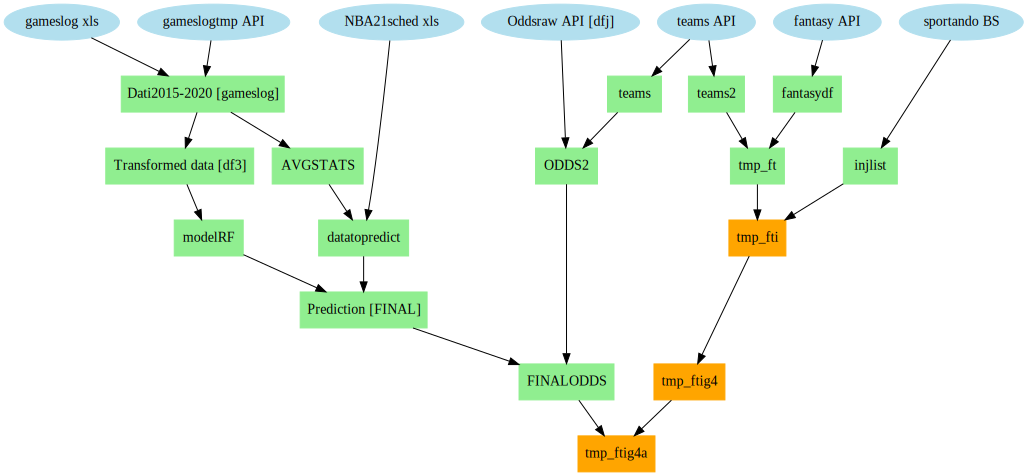

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

from graphviz import Digraph
uu = Digraph(comment='NBA Predict',node_attr={'color': 'lightblue2', 'style': 'filled'})
uu.attr(size='20,10')

with uu.subgraph() as s:
    s.attr(rank='same')
    s.node('gameslogtmp API')
    s.node('gameslog xls')
    s.node('NBA21sched xls')
    s.node('Oddsraw API [dfj]')
    s.node('fantasy API')
    s.node('teams API')
    s.node('sportando BS')
 
uu.attr('node', shape='box', style='filled', color='lightgreen')

uu.edge('teams API','teams2')
uu.edge('teams API','teams')

uu.edge('gameslogtmp API','Dati2015-2020 [gameslog]')
uu.edge('gameslog xls','Dati2015-2020 [gameslog]')
uu.edge('Dati2015-2020 [gameslog]','AVGSTATS')
uu.edge('Dati2015-2020 [gameslog]','Transformed data [df3]')
uu.edge('Transformed data [df3]','modelRF')
uu.edge('AVGSTATS','datatopredict')
uu.edge('NBA21sched xls','datatopredict')
uu.edge('teams','ODDS2')
uu.edge('Oddsraw API [dfj]','ODDS2')
uu.edge('modelRF','Prediction [FINAL]')
uu.edge('datatopredict','Prediction [FINAL]')
uu.edge('ODDS2','FINALODDS')
uu.edge('Prediction [FINAL]','FINALODDS')

uu.attr('node', shape='box', style='filled', color='lightgreen')
uu.edge('fantasy API','fantasydf')
uu.edge('sportando BS','injlist')
uu.edge('teams2', 'tmp_ft')
uu.edge('fantasydf', 'tmp_ft')

uu.attr('node', shape='box', style='filled', color='orange')
uu.edge('injlist', 'tmp_fti')
uu.edge('tmp_ft', 'tmp_fti')
uu.edge('tmp_fti', 'tmp_ftig4')
uu.edge('tmp_ftig4','tmp_ftig4a')
uu.edge('FINALODDS','tmp_ftig4a')

uu.attr('node', shape='box', color='white')
print ('tmp_fti,dettaglio per giocatore con infortuni squadra e stats')
print ('tmp_ftig4,aggregato per squadra con dati giocatori disponibili vs non attivi')
print ('tmp_ftig4a,daily ODDS con info fantasy+inj')
print ('')

uu


### LOAD LOCAL DATABASE 

In [73]:
#LOAD LOCAL DATABASE 

import pandas as pd 
import datetime
import numpy as np

gameslogH = pd.read_excel('NBA2020analytics_gamesraw_backup.xls', index_col=0)  
print('gameslogH',gameslogH.shape)
gameslogH = gameslogH.dropna()
max = gameslogH ["GAME_DATE_EST"].max()
min = gameslogH ["GAME_DATE_EST"].min()
print(min,max)


gameslogH (24014, 31)
2015-12-26 00:00:00 2020-12-28 00:00:00


In [58]:
gameslogH

,GAME_DATE_EST,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,year,YEAR
0,2015-12-26,1,21500447,1610612764,WAS,Washington,Wizards,14-14,34,18,27,32,0,0,0,0,0,0,0,0,0,0,111,0.500,0.682,0.444,32,39,11,2015,2015
1,2015-12-26,1,21500447,1610612751,BKN,Brooklyn,Nets,8-22,26,24,27,19,0,0,0,0,0,0,0,0,0,0,96,0.483,0.313,0.294,24,50,19,2015,2015
2,2015-12-26,2,21500441,1610612761,TOR,Toronto,Raptors,19-12,22,34,20,35,0,0,0,0,0,0,0,0,0,0,111,0.519,0.737,0.448,31,44,8,2015,2015
3,2015-12-26,2,21500441,1610612749,MIL,Milwaukee,Bucks,12-19,17,35,27,11,0,0,0,0,0,0,0,0,0,0,90,0.420,0.889,0.429,25,38,13,2015,2015
4,2015-12-26,3,21500443,1610612763,MEM,Memphis,Grizzlies,16-16,28,25,21,18,0,0,0,0,0,0,0,0,0,0,92,0.411,0.524,0.368,21,48,13,2015,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2020-12-28,3,22000043,1610612760,OKC,Oklahoma City,Thunder,1-1,24,28,35,22,0,0,0,0,0,0,0,0,0,0,109,0.465,0.737,0.395,21,37,15,2020,2020
6,2020-12-28,4,22000044,1610612745,HOU,Houston,Rockets,0-2,26,34,23,28,0,0,0,0,0,0,0,0,0,0,111,0.453,0.739,0.410,25,38,15,2020,2020
7,2020-12-28,4,22000044,1610612743,DEN,Denver,Nuggets,1-2,36,34,36,18,0,0,0,0,0,0,0,0,0,0,124,0.529,0.563,0.452,31,52,14,2020,2020
8,2020-12-28,5,22000045,1610612757,POR,Portland,Trail Blazers,2-1,22,36,26,31,0,0,0,0,0,0,0,0,0,0,115,0.467,0.867,0.348,27,45,9,2020,2020


### QUERY NEW DATA

In [3]:

from tqdm import trange
from datetime import date
from datetime import datetime, timedelta
import datetime
from nba_api.stats.endpoints import scoreboardv2
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 
import numpy as np

today = date.today()

gameslogtmp = []
for x in trange(2):
    d = datetime.date(2021, 1, 5)
    tmpdate = d - timedelta(x)
    output = scoreboardv2.ScoreboardV2(game_date=tmpdate, league_id='00',timeout=15000).get_data_frames()
    tmp = pd.DataFrame(output[1])
    gameslogtmp= tmp.append(gameslogtmp, ignore_index=True)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


In [74]:
print('gameslogtmp',gameslogtmp.shape)
gameslogtmp = gameslogtmp.dropna()
max = gameslogtmp ["GAME_DATE_EST"].max()
min = gameslogtmp ["GAME_DATE_EST"].min()
print(min,max)

gameslogtmp (28, 29)
2021-01-04T00:00:00 2021-01-05T00:00:00


### MERGE LOCAL WITH NEW DATA 
- gameslogH = dati caricati da XLS 
- gameslogtmp = dati new 
- gameslog = il DF finale, backuppato anche su csv e XLS 


In [75]:
print(gameslogH.shape)
print(gameslogtmp.shape)
gameslog=gameslogH.append(gameslogtmp)

import datetime 
gameslog['GAME_DATE_EST'] = pd.to_datetime(gameslog['GAME_DATE_EST']) # convert to date  
gameslog['YEAR'] = gameslog['GAME_DATE_EST'].dt.to_period('Y')  # create column Year
print(gameslog.groupby(['YEAR']).size())
print(gameslog ["GAME_DATE_EST"].min(),gameslog ["GAME_DATE_EST"].max())
print(gameslog.shape)

gameslog.to_csv('NBA2020analytics_gamesraw_backup.csv', index=False)
gameslog.to_excel('NBA2020analytics_gamesraw_backup.xls')

(23986, 31)
(28, 29)
YEAR
2015     196
2016    5740
2017    5704
2018    5584
2019    5218
2020    1544
2021      28
Freq: A-DEC, dtype: int64
2015-12-26 00:00:00 2021-01-05 00:00:00
(24014, 31)


### Transform data in game data ( one line per match ) 

In [6]:
print('gameslog',gameslog.shape)

df1=gameslog[['YEAR','GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY_NAME','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2=df1[['YEAR','GAME_DATE_EST','GAME_ID','TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2

df3 = pd.DataFrame([y.values.ravel() for x , y in df2.groupby(np.arange(len(df2))//2)])
df3.columns= ['YEARA','DATEA','GAME_IDA','TEAMA','PTSA','FG_PCTA','FT_PCTA','FG3_PCTA','ASTA','REBA','TOVA','YEARH','DATEH','GAME_IDH','TEAMH','PTSH','FG_PCTH','FT_PCTH','FG3_PCTH','ASTH','REBH','TOVH'] #COLUMNSRENAME
df3=df3[['YEARA','DATEA','GAME_IDH','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT
df3['WIN']=''

for i, row in df3.iterrows():
    if (row['PTSH']> row['PTSA']):
        df3.at[i,'WINTEAMNAME'] = row['TEAMH']
        df3.at[i,'WINTEAMNUM'] = 1
    else:
        df3.at[i,'WINTEAMNAME'] = row['TEAMA']
        df3.at[i,'WINTEAMNUM'] = 0

print(df3.groupby(['YEARA']).size())
df3.head()

gameslog (24014, 31)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     772
2021      14
Freq: A-DEC, dtype: int64


,YEARA,DATEA,GAME_IDH,TEAMH,PTSH,TEAMA,PTSA,FG_PCTH,FG_PCTA,FT_PCTH,...,FG3_PCTA,ASTH,ASTA,REBH,REBA,TOVH,TOVA,WIN,WINTEAMNAME,WINTEAMNUM
0,2015,2015-12-26,21500447,BKN,96,WAS,111,0.483,0.500,0.313,...,0.444,24,32,50,39,19,11,,WAS,0.0
1,2015,2015-12-26,21500441,MIL,90,TOR,111,0.420,0.519,0.889,...,0.448,25,31,38,44,13,8,,TOR,0.0
2,2015,2015-12-26,21500443,CHA,98,MEM,92,0.406,0.411,0.875,...,0.368,21,21,43,48,16,13,,CHA,1.0
3,2015,2015-12-26,21500444,ORL,101,MIA,108,0.544,0.494,0.462,...,0.500,31,22,34,38,9,8,,MIA,0.0
4,2015,2015-12-26,21500445,NOP,110,HOU,108,0.507,0.452,0.808,...,0.455,25,21,40,35,15,10,,NOP,1.0


In [298]:
df3[(df3.DATEA=='2021-01-04')]

,YEARA,DATEA,GAME_IDH,TEAMH,PTSH,TEAMA,PTSA,FG_PCTH,FG_PCTA,FT_PCTH,FT_PCTA,FG3_PCTH,FG3_PCTA,ASTH,ASTA,REBH,REBA,TOVH,TOVA,WIN,WINTEAMNAME,WINTEAMNUM
11993,2021,2021-01-04,0022000093,ORL,103,CLE,83,0.43,0.38,0.92,0.58,0.44,0.36,22,20,54,36,19,14,,ORL,1.00
11994,2021,2021-01-04,0022000094,PHI,118,CHA,101,0.48,0.42,0.65,0.73,0.34,0.33,34,30,55,46,10,16,,PHI,1.00
11995,2021,2021-01-04,0022000095,ATL,108,NYK,113,0.46,0.51,0.78,0.80,0.32,0.33,24,26,40,45,12,15,,NYK,0.00
11996,2021,2021-01-04,0022000096,MIA,118,OKC,90,0.57,0.37,0.56,0.70,0.47,0.27,34,20,47,38,14,15,,MIA,1.00
11997,2021,2021-01-04,0022000097,TOR,114,BOS,126,0.40,0.49,0.76,0.85,0.35,0.52,20,19,37,56,10,19,,BOS,0.00
11998,2021,2021-01-04,0022000098,HOU,100,DAL,113,0.39,0.48,0.81,0.95,0.28,0.41,17,24,35,51,12,15,,DAL,0.00
11999,2021,2021-01-04,0022000099,MIL,125,DET,115,0.58,0.44,0.81,1.00,0.41,0.42,32,27,49,31,19,8,,MIL,1.00
12000,2021,2021-01-04,0022000100,NOP,116,IND,118,0.44,0.48,0.79,0.69,0.33,0.42,26,32,57,42,18,14,,IND,0.00
12001,2021,2021-01-04,0022000101,GSW,137,SAC,106,0.53,0.38,0.86,0.72,0.54,0.29,41,20,48,51,11,14,,GSW,1.00


In [7]:
df3.to_csv('NBA2020analytics_gamestransformed_backup.csv', index=False)
df3.to_excel('NBA2020analytics_gamestransformed_backup.xls')

In [72]:
df3=df3.loc[df3['YEARA'] == '2020']
df3.shape

(810, 22)

### Create DecisionTree and Random Forest

In [9]:
# OPTIONAL - LOAD LOCAL gamestransformed FILE 

import pandas as pd 
import numpy as np
df3 = pd.read_excel('NBA2020analytics_gamestransformed_backup.xls', index_col=0)  
print('df3',df3.shape)
print(df3.groupby(['YEARA']).size())


df3 (12007, 22)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     772
2021      14
dtype: int64


### 1 DecisionTree

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

modelDT = DecisionTreeRegressor(max_leaf_nodes=10, random_state=1)
modelDT.fit(train_X, train_y)
preds_val = modelDT.predict(val_X)
print("DecisionTreeRegressor")
print(mean_absolute_error(val_y, preds_val))
modelDT_mae= mean_absolute_error(val_y, preds_val)


(9005, 12) (3002, 12)
DecisionTreeRegressor
0.30139878843884166


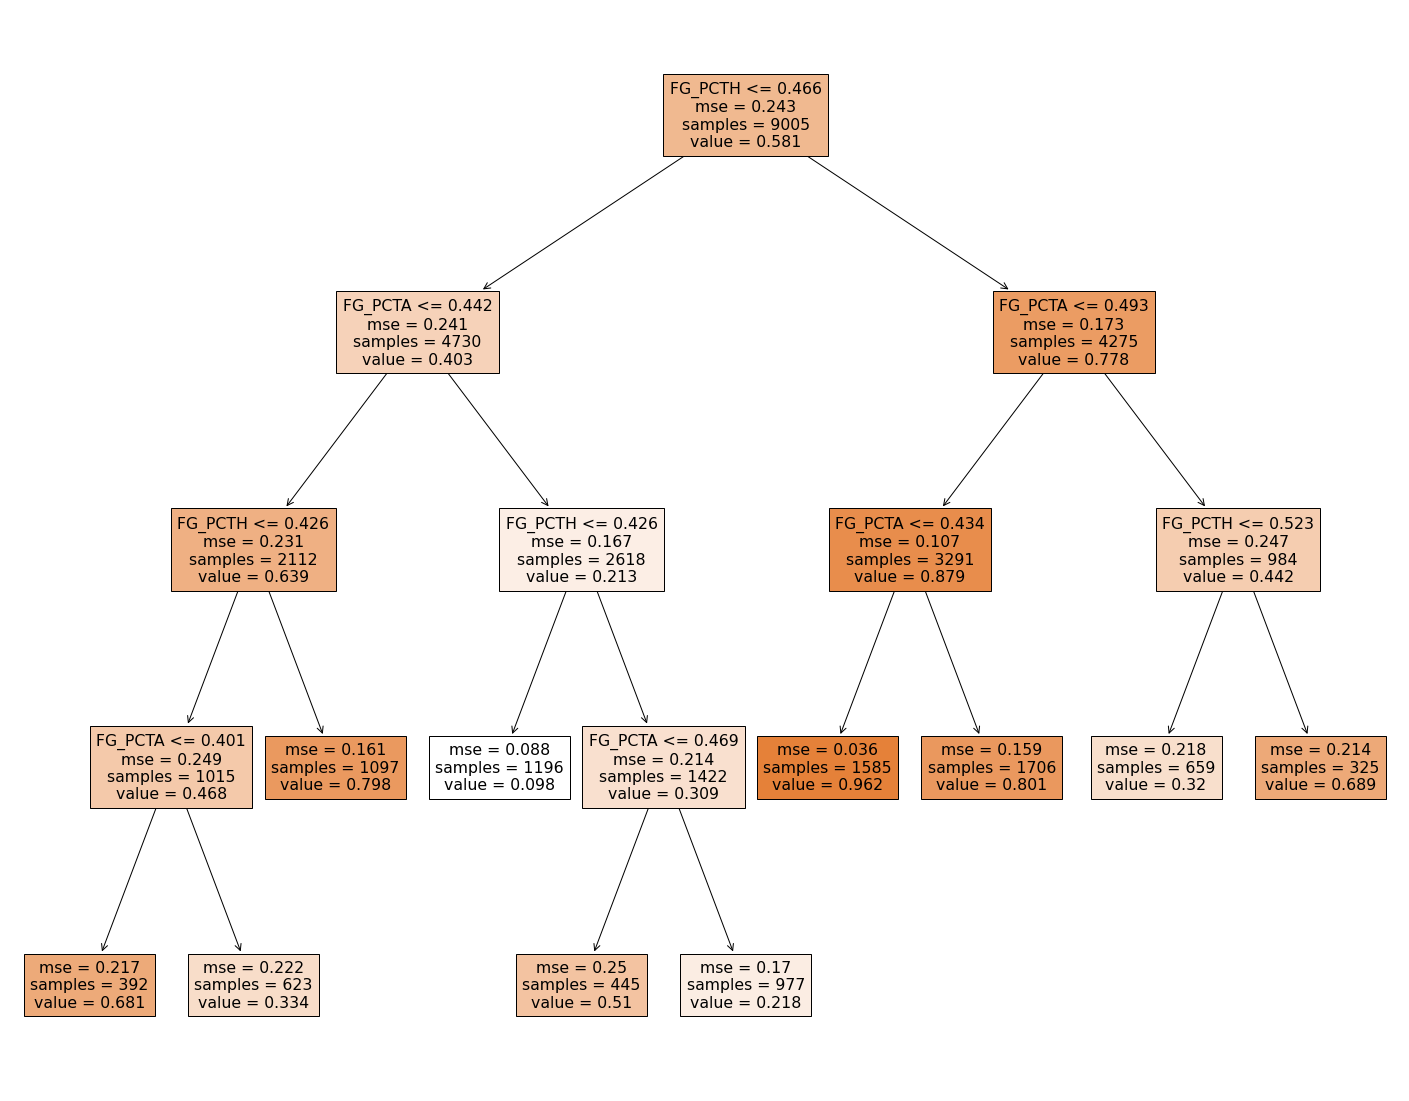

In [11]:
#https://mljar.com/blog/visualize-decision-tree/

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelDT,feature_names=val_X.columns, filled=True)

 #1 TEAMH , 0 TEAMA

### 2 Random Forest

In [12]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

# #TEST TO OPTIMIZE n_estimators + max_depth
# start_time = time.time()
# for j in [1,2,25,50,100]:
#     modelRF = RandomForestClassifier(n_estimators=j,max_depth=25, random_state=0)
#     modelRF.fit(train_X, train_y)
#     preds_val = modelRF.predict(val_X)
#     modelRF_mae=mean_absolute_error(val_y, preds_val)
#     print("depth %.1f  mae %.4f " % (j,modelRF_mae))
# print("TOT seconds ","%.2f" %(time.time() - start_time))

start_time = time.time()
modelRF = RandomForestRegressor(max_depth=25, random_state=0)
modelRF.fit(train_X, train_y)
preds_val = modelRF.predict(val_X)
modelRF_mae=mean_absolute_error(val_y, preds_val)
print("RandomForestRegressor mae : %.4f " % (modelRF_mae))
print("TOT seconds ","%.2f" %(time.time() - start_time))


(9005, 12) (3002, 12)
RandomForestRegressor mae : 0.1195 
TOT seconds  3.78


In [13]:
import pickle
import sys

print("DT model size MB:", sys.getsizeof(pickle.dumps(modelDT))/1000000)
print("RF model size MB:", sys.getsizeof(pickle.dumps(modelRF))/1000000)

DT model size MB: 0.002213
RF model size MB: 7.17109


<div class="alert-warning">
        
## PREDICTION WITH BOTH MODELS 
     
</div>

## ( CALENDAR + AVG STATS ) + MODEL = PREDICTION 

In [245]:
gameslog

,GAME_DATE_EST,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,year,YEAR
0,2015-12-26,1,21500447,1610612764,WAS,Washington,Wizards,14-14,34,18,27,32,0,0,0,0,0,0,0,0,0,0,111,0.50,0.68,0.44,32,39,11,"2,015.00",2015
1,2015-12-26,1,21500447,1610612751,BKN,Brooklyn,Nets,8-22,26,24,27,19,0,0,0,0,0,0,0,0,0,0,96,0.48,0.31,0.29,24,50,19,"2,015.00",2015
2,2015-12-26,2,21500441,1610612761,TOR,Toronto,Raptors,19-12,22,34,20,35,0,0,0,0,0,0,0,0,0,0,111,0.52,0.74,0.45,31,44,8,"2,015.00",2015
3,2015-12-26,2,21500441,1610612749,MIL,Milwaukee,Bucks,12-19,17,35,27,11,0,0,0,0,0,0,0,0,0,0,90,0.42,0.89,0.43,25,38,13,"2,015.00",2015
4,2015-12-26,3,21500443,1610612763,MEM,Memphis,Grizzlies,16-16,28,25,21,18,0,0,0,0,0,0,0,0,0,0,92,0.41,0.52,0.37,21,48,13,"2,015.00",2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2021-01-04,7,0022000099,1610612749,MIL,Milwaukee,Bucks,4-3,33,34,30,28,0,0,0,0,0,0,0,0,0,0,125,0.58,0.81,0.41,32,49,19,nan,2021
14,2021-01-04,8,0022000100,1610612754,IND,Indiana,Pacers,5-2,26,27,26,27,12,0,0,0,0,0,0,0,0,0,118,0.48,0.69,0.42,32,42,14,nan,2021
15,2021-01-04,8,0022000100,1610612740,NOP,New Orleans,Pelicans,4-3,24,27,26,29,10,0,0,0,0,0,0,0,0,0,116,0.44,0.79,0.33,26,57,18,nan,2021
16,2021-01-04,9,0022000101,1610612758,SAC,Sacramento,Kings,3-4,20,28,27,31,0,0,0,0,0,0,0,0,0,0,106,0.38,0.72,0.29,20,51,14,nan,2021


In [14]:
import numpy as np
import pandas as pd
import datetime

#2 COMPUTE AVG STATS 

pd.options.display.float_format = '{:,.2f}'.format
gameslogHZ=gameslog.loc[gameslog['YEAR'] == '2020']
gameslogHZ=gameslogHZ[['TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
cols = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB','TOV']
gameslogHZ[cols] = gameslogHZ[cols].astype('float')
gameslogHP = gameslogHZ.groupby('TEAM_ABBREVIATION').mean().reset_index()

gameslogHP.head(2)

,TEAM_ABBREVIATION,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV
0,ATL,117.05,0.45,0.82,0.36,24.90,45.49,15.07
1,BKN,111.80,0.45,0.75,0.36,25.00,46.76,14.57


In [62]:
import numpy as np
import pandas as pd
import datetime

#1 LOAD CALENDAR

df = pd.read_csv("NBA2021schedule.csv",sep=";")
df=df.loc[df['Value'].str.startswith('@') == False]
df=df.rename(columns={"Value": "AWAY", "Attribute": "HOME"})
df = df[['GAMEDATE','HOME','AWAY']]
df['AWAY'] = df['AWAY'].apply(lambda x: x.upper())
df['HOME'] = df['HOME'].apply(lambda x: x.upper())
df= df.reset_index()
df['HOME'] = df['HOME'].str.replace('PHO','PHX')
df['AWAY'] = df['AWAY'].str.replace('PHO','PHX')
df['HOME'] = df['HOME'].str.replace('NOR','NOP')
df['AWAY'] = df['AWAY'].str.replace('NOR','NOP')
df['HOME'] = df['HOME'].str.replace('NO','NOP')
df['AWAY'] = df['AWAY'].str.replace('NO','NOP')
df['HOME'] = df['HOME'].str.replace('NY','NYK')
df['AWAY'] = df['AWAY'].str.replace('NY','NYK')
df['HOME'] = df['HOME'].str.replace('SA','SAS')
df['AWAY'] = df['AWAY'].str.replace('SA','SAS')
df['HOME'] = df['HOME'].str.replace('SASS','SAS')
df['AWAY'] = df['AWAY'].str.replace('SASS','SAS')
df['HOME'] = df['HOME'].str.replace('UTH','UTA')
df['AWAY'] = df['AWAY'].str.replace('UTH','UTA')
NBA21sched = df

#2 COMPUTE AVG STATS 

pd.options.display.float_format = '{:,.2f}'.format
gameslogHZ=gameslog.loc[gameslog['YEAR'] == '2020']
gameslogHZ=gameslogHZ[['TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
cols = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB','TOV']
gameslogHZ[cols] = gameslogHZ[cols].astype('float')
gameslogHP = gameslogHZ.groupby('TEAM_ABBREVIATION').mean().reset_index()

#3 MERGE CALENDAR + AVG STATS 

gameslogHP = gameslogHP.rename(columns={'TEAM_ABBREVIATION': 'HOME'})
tmpp = pd.merge(gameslogHP, NBA21sched)
tmpp.columns= ['HOME', 'PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE', 'AWAY']
gameslogHP = gameslogHP.rename(columns={'HOME': 'AWAY'})
tmp2 = pd.merge(gameslogHP, tmpp)
tmp2.columns = ['TEAMA', 'PTSH', 'FG_PCTH', 'FT_PCTH', 'FG3_PCTH', 'ASTH', 'REBH', 'TOVH','TEAMH','PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE']
AVGSTATS=tmp2[['GAMEDATE','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT

# 4 DATAFRAME datatopredict
AVGSTATS.head(3)
datatopredict=AVGSTATS[['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']]
datatopredict.head(3)

# 5 MAKE PREDICTION 

resultDT = modelDT.predict(datatopredict)
resultRF = modelRF.predict(datatopredict)
np.set_printoptions(precision=2)
PREDICT_OUT = pd.DataFrame({'resultDT':resultDT, 'resultRF':resultRF})
FINAL = pd.merge(PREDICT_OUT, datatopredict, left_index=True, right_index=True)
FINAL

#6 ADD TEAM INFO AND WINNER NAME

tmp21=AVGSTATS[['GAMEDATE', 'TEAMH','TEAMA']]
FINAL= pd.merge(FINAL, tmp21, left_index=True, right_index=True)

i=0
for index, row in FINAL.iterrows():
    FINAL.at[i, 'GAMEDATE2'] = datetime.datetime.strptime(row['GAMEDATE'], '%d/%m/%Y')
    FINAL.at[i, 'GAMETEAMS'] = row['TEAMH']+row['TEAMA']
    FINAL.at[i, 'WINNER_ID'] = round(row['resultRF'])
    if (round(row['resultRF'])==0):    #1 TEAMH , 0 TEAMA
        win=row['TEAMA']
    else:
        win=row['TEAMH']
    FINAL.at[i, 'WINNER_NAME'] = win
    i=i+1

FINAL=FINAL.sort_values(by='GAMEDATE2', ascending=True)

print(NBA21sched.shape,gameslogHP.shape,AVGSTATS.shape,datatopredict.shape,FINAL.shape)
FINAL



(558, 4) (32, 8) (486, 17) (486, 12) (486, 21)


,resultDT,resultRF,FG_PCTH,FG_PCTA,FT_PCTH,FT_PCTA,FG3_PCTH,FG3_PCTA,ASTH,ASTA,REBH,REBA,TOVH,TOVA,GAMEDATE,TEAMH,TEAMA,GAMEDATE2,GAMETEAMS,WINNER_ID,WINNER_NAME
229,0.80,0.66,0.47,0.48,0.79,0.74,0.37,0.36,23.19,24.77,45.81,45.27,13.02,14.70,22/12/2020,LAL,LAC,2020-12-22,LALLAC,1.00,LAL
165,0.51,0.21,0.44,0.45,0.79,0.75,0.33,0.36,26.47,25.00,42.44,46.76,14.81,14.57,22/12/2020,BKN,GSW,2020-12-22,BKNGSW,0.00,GSW
419,0.51,0.57,0.47,0.47,0.82,0.75,0.38,0.34,24.65,26.43,43.81,48.20,12.19,14.73,23/12/2020,MEM,SAS,2020-12-23,MEMSAS,1.00,MEM
464,0.80,0.69,0.48,0.46,0.78,0.79,0.38,0.38,22.79,21.23,44.34,44.11,13.82,12.42,23/12/2020,POR,UTA,2020-12-23,PORUTA,1.00,POR
292,0.80,0.87,0.47,0.46,0.75,0.80,0.35,0.36,25.02,22.56,50.28,45.61,14.96,13.64,23/12/2020,BOS,MIL,2020-12-23,BOSMIL,1.00,BOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0.22,0.58,0.47,0.48,0.80,0.72,0.37,0.37,26.16,27.78,42.44,46.96,13.21,16.20,04/03/2021,NOP,MIA,2021-03-04,NOPMIA,1.00,NOP
298,0.80,0.82,0.47,0.47,0.75,0.75,0.35,0.34,25.02,26.43,50.28,48.20,14.96,14.73,04/03/2021,MEM,MIL,2021-03-04,MEMMIL,1.00,MEM
345,0.51,0.36,0.46,0.47,0.79,0.82,0.37,0.38,21.47,24.65,44.45,43.81,13.45,12.19,04/03/2021,SAS,OKC,2021-03-04,SASOKC,0.00,OKC
431,0.51,0.55,0.45,0.46,0.78,0.80,0.37,0.36,25.30,22.56,44.47,45.61,14.11,13.64,04/03/2021,BOS,TOR,2021-03-04,BOSTOR,1.00,BOS


<div class="alert-warning">
        
# ODDS 
     
</div>

In [16]:
import json
import requests

api_key = '47790af09458f96c2b9a9a5c4a0f7617'

# First get a list of in-season sports
# sports_response = requests.get('https://api.the-odds-api.com/v3/sports', params={'api_key': api_key})
# sports_json = json.loads(sports_response.text)
# if not sports_json['success']:
#     print('There was a problem with the sports request:',sports_json['msg'])
# else:
#     print('Successfully got {} sports'.format(len(sports_json['data'])),'Here\'s the first sport:')
#     print(sports_json['data'][0])

# To get odds for a sepcific sport, use the sport key from the last request
#   or set sport to "upcoming" to see live and upcoming across all sports
sport_key = 'basketball_nba'

odds_response = requests.get('https://api.the-odds-api.com/v3/odds', params={
    'api_key': api_key,
    'sport': sport_key,
    'region': 'eu', # uk | us | eu | au
    'mkt': 'h2h' # h2h | spreads | totals
})

odds_json = json.loads(odds_response.text)

if not odds_json['success']:
    print('There was a problem with the odds request:',odds_json['msg'])
else:
    # odds_json['data'] contains a list of live and 
    #   upcoming events and odds for different bookmakers.
    # Events are ordered by start time (live events are first)
    print('Successfully got {} events'.format(len(odds_json['data'])),'Here\'s the first event:')
    print(odds_json['data'][0])
        
    # Check your usage
    print('Remaining requests', odds_response.headers['x-requests-remaining'])
    print('Used requests', odds_response.headers['x-requests-used'])


Successfully got 11 events Here's the first event:
{'sport_key': 'basketball_nba', 'sport_nice': 'NBA', 'teams': ['Houston Rockets', 'Indiana Pacers'], 'commence_time': 1609978200, 'home_team': 'Indiana Pacers', 'sites': [{'site_key': 'marathonbet', 'site_nice': 'Marathon Bet', 'last_update': 1609929650, 'odds': {'h2h': [2.14, 1.79]}}, {'site_key': 'betclic', 'site_nice': 'Betclic', 'last_update': 1609929897, 'odds': {'h2h': [2.17, 1.82, 14.5]}}, {'site_key': 'bookmaker', 'site_nice': 'Bookmaker', 'last_update': 1609929675, 'odds': {'h2h': [2.08, 1.78]}}, {'site_key': 'nordicbet', 'site_nice': 'Nordic Bet', 'last_update': 1609929966, 'odds': {'h2h': [2.1, 1.75]}}, {'site_key': 'pinnacle', 'site_nice': 'Pinnacle', 'last_update': 1609929873, 'odds': {'h2h': [2.14, 1.79]}}, {'site_key': 'williamhill', 'site_nice': 'William Hill', 'last_update': 1609929277, 'odds': {'h2h': [2.1, 1.77]}}, {'site_key': 'betfair', 'site_nice': 'Betfair', 'last_update': 1609929971, 'odds': {'h2h': [2.2, 1.81],

In [308]:
dfj

,teams,commence_time,home_team,team1,team2,AvgOdds1,AvgOdds2,MinOdds1,MinOdds2,MaxOdds1,MaxOdds2
0,"[Brooklyn Nets, Utah Jazz]",1609893600,Brooklyn Nets,Brooklyn Nets,Utah Jazz,2.10,1.76,2.02,1.71,2.21,1.80
1,"[Los Angeles Lakers, Memphis Grizzlies]",1609895400,Memphis Grizzlies,Los Angeles Lakers,Memphis Grizzlies,1.22,4.64,1.21,4.40,1.23,4.80
2,"[Denver Nuggets, Minnesota Timberwolves]",1609899000,Denver Nuggets,Denver Nuggets,Minnesota Timberwolves,1.12,6.66,1.12,6.30,1.12,6.88
3,"[Los Angeles Clippers, San Antonio Spurs]",1609902600,Los Angeles Clippers,Los Angeles Clippers,San Antonio Spurs,1.27,2.51,1.25,1.02,1.28,4.00
4,"[Chicago Bulls, Portland Trail Blazers]",1609904400,Portland Trail Blazers,Chicago Bulls,Portland Trail Blazers,4.93,1.19,4.84,1.18,5.00,1.20


In [17]:
dfj = pd.json_normalize(odds_json['data'])
dfj = dfj[['teams', 'commence_time', 'home_team']]
print(dfj.shape[0])

j=0

for index, row in dfj.iterrows():
    dfj.at[j, 'team1'] = odds_json['data'][j]['teams'][0]
    dfj.at[j, 'team2'] = odds_json['data'][j]['teams'][1]
    
    try:
        dfj.at[j, 'site1'] = odds_json['data'][j]['sites'][0]['site_key']
    except IndexError:
        pass
    
    try:
        dfj.at[j, 'site1'] = odds_json['data'][j]['sites'][1]['site_key']
    except IndexError:
        pass
 
    try:
        dfj.at[j, 'site1'] = odds_json['data'][j]['sites'][2]['site_key']
    except IndexError:
        pass
    
    try:
        dfj.at[j, 's1odds1'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][0]
    except IndexError:
        pass
    
    try:
        dfj.at[j, 's2odds1'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][0]
    except IndexError:
        pass    
    
    try:
        dfj.at[j, 's3odds1'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][0]
    except IndexError:
        pass    
    
    try:
        dfj.at[j, 's1odds2'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][1]
    except IndexError:
        pass    
 
    try:
        dfj.at[j, 's2odds2'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][1]
    except IndexError:
        pass    
    
    try:
        dfj.at[j, 's3odds2'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][1]
    except IndexError:
        pass    
    
    j=j+1

col = dfj.loc[: , "s1odds1":"s3odds1"]
dfj['MinOdds1'] = col.min(axis=1)
dfj['MaxOdds1'] = col.max(axis=1)
dfj['AvgOdds1'] = col.mean(axis=1)
col = dfj.loc[: , "s1odds2":"s3odds2"]
dfj['MinOdds2'] = col.min(axis=1)
dfj['MaxOdds2'] = col.max(axis=1)
dfj['AvgOdds2'] = col.mean(axis=1)

dfj = dfj[['teams', 'commence_time', 'home_team', 'team1', 'team2','AvgOdds1','AvgOdds2','MinOdds1','MinOdds2', 'MaxOdds1','MaxOdds2']]
dfj.head()

11


,teams,commence_time,home_team,team1,team2,AvgOdds1,AvgOdds2,MinOdds1,MinOdds2,MaxOdds1,MaxOdds2
0,"[Houston Rockets, Indiana Pacers]",1609978200,Indiana Pacers,Houston Rockets,Indiana Pacers,2.13,1.80,2.08,1.78,2.17,1.82
1,"[Philadelphia 76ers, Washington Wizards]",1609978200,Philadelphia 76ers,Philadelphia 76ers,Washington Wizards,1.39,3.26,1.38,3.18,1.40,3.35
2,"[Cleveland Cavaliers, Orlando Magic]",1609978200,Orlando Magic,Cleveland Cavaliers,Orlando Magic,2.97,1.44,2.88,1.43,3.07,1.45
3,"[Boston Celtics, Miami Heat]",1609980000,Miami Heat,Boston Celtics,Miami Heat,2.18,1.76,2.12,1.75,2.22,1.78
4,"[Atlanta Hawks, Charlotte Hornets]",1609980000,Atlanta Hawks,Atlanta Hawks,Charlotte Hornets,1.42,3.09,1.40,3.06,1.44,3.15


In [18]:
# ADD TEAMS SHORT NAME + HOME/AWAY + KEY 

import pandas 
pandas.options.display.float_format = '{:,.2f}'.format

from nba_api.stats.static import teams
import pandas as pd
teams = pd.DataFrame(teams.get_teams())
teams=teams[['full_name', 'abbreviation']]
teams.head()

teams = teams.rename(columns={'full_name': 'team1','abbreviation': 'team1S'})
odds1 = pd.merge(dfj, teams)
teams = teams.rename(columns={'team1': 'team2','team1S': 'team2S'})
odds2 = pd.merge(odds1, teams)

odds2

i=0
for i, row in odds2.iterrows():
    if row['home_team']==row['team1']:
        tteamh=row['team1S']
        tteama=row['team2S']
        odds2.at[i, 'AvgOddsH']=row['AvgOdds1']
        odds2.at[i, 'MinOddsH']=row['MinOdds1']
        odds2.at[i, 'MaxOddsH']=row['MaxOdds1']
        odds2.at[i, 'AvgOddsA']=row['AvgOdds2']
        odds2.at[i, 'MinOddsA']=row['MinOdds2']
        odds2.at[i, 'MaxOddsA']=row['MaxOdds2']
    else:
        tteamh=row['team2S']
        tteama=row['team1S']
        odds2.at[i, 'AvgOddsA']=row['AvgOdds1']
        odds2.at[i, 'MinOddsA']=row['MinOdds1']
        odds2.at[i, 'MaxOddsA']=row['MaxOdds1']
        odds2.at[i, 'AvgOddsH']=row['AvgOdds2']
        odds2.at[i, 'MinOddsH']=row['MinOdds2']
        odds2.at[i, 'MaxOddsH']=row['MaxOdds2']
        
    odds2.at[i, 'TEAMH'] = tteamh
    odds2.at[i, 'TEAMA'] = tteama
    odds2.at[i, 'GAMETEAMS'] = tteamh+tteama
    i=i+1

odds2=odds2[['TEAMH', 'TEAMA', 'GAMETEAMS','AvgOddsA', 'MinOddsA', 'MaxOddsA', 'AvgOddsH', 'MinOddsH','MaxOddsH']]
odds2

,TEAMH,TEAMA,GAMETEAMS,AvgOddsA,MinOddsA,MaxOddsA,AvgOddsH,MinOddsH,MaxOddsH
0,IND,HOU,INDHOU,2.13,2.08,2.17,1.80,1.78,1.82
1,PHI,WAS,PHIWAS,3.26,3.18,3.35,1.39,1.38,1.40
2,ORL,CLE,ORLCLE,2.97,2.88,3.07,1.44,1.43,1.45
3,MIA,BOS,MIABOS,2.18,2.12,2.22,1.76,1.75,1.78
4,ATL,CHA,ATLCHA,3.09,3.06,3.15,1.42,1.40,1.44
5,NYK,UTA,NYKUTA,1.40,1.38,1.43,3.12,3.07,3.19
6,NOP,OKC,NOPOKC,3.84,3.76,3.90,1.30,1.29,1.30
7,MIL,DET,MILDET,8.50,8.10,9.20,1.09,1.07,1.11
8,PHX,TOR,PHXTOR,2.37,2.31,2.43,1.66,1.65,1.67
9,SAC,CHI,SACCHI,3.39,3.30,3.56,1.36,1.35,1.36


<div class="alert-warning">
        
# ODDS + PREDICTION
     
</div>

In [19]:
from datetime import date
print(odds2.shape)
FINALODDS = pd.merge(FINAL, odds2)

FINALODDS=FINALODDS[['TEAMH', 'TEAMA', 'WINNER_NAME','resultRF','AvgOddsA', 'MinOddsA', 'MaxOddsA', 'AvgOddsH', 'MinOddsH','MaxOddsH','GAMEDATE2']]

FINALODDS

i=0
for index, row in FINALODDS.iterrows():
    if (row['WINNER_NAME']==row['TEAMH']):
        FINALODDS.at[i, 'AvgOddsW']=row['AvgOddsH']
        FINALODDS.at[i, 'MinOddsW']=row['MinOddsH']
        FINALODDS.at[i, 'MaxOddsW']=row['MaxOddsH']
        FINALODDS.at[i, 'AvgOddsL']=row['AvgOddsA']
        FINALODDS.at[i, 'MinOddsL']=row['MinOddsA']
        FINALODDS.at[i, 'MaxOddsL']=row['MaxOddsA']
    else:
        FINALODDS.at[i, 'AvgOddsW']=row['AvgOddsA']
        FINALODDS.at[i, 'MinOddsW']=row['MinOddsA']
        FINALODDS.at[i, 'MaxOddsW']=row['MaxOddsA']
        FINALODDS.at[i, 'AvgOddsL']=row['AvgOddsH']
        FINALODDS.at[i, 'MinOddsL']=row['MinOddsH']
        FINALODDS.at[i, 'MaxOddsL']=row['MaxOddsH']
    i=i+1

FINALODDS=FINALODDS[['TEAMH', 'TEAMA', 'WINNER_NAME','resultRF','AvgOddsA','AvgOddsH','GAMEDATE2']]
FINALODDS.sort_values(by='GAMEDATE2', ascending=True)
# #FIX2

d1 = date.today().strftime("%Y-%m-%d")
FINALODDS=FINALODDS[(FINALODDS.GAMEDATE2==d1)]

(11, 9)


In [20]:
FINALODDS.to_csv('NBA2020_Prediction_out.csv', index=False)
FINALODDS.to_excel('NBA2020_Prediction_out.xls')

<div class="alert-warning">
        
# PLAYER STATS VS INJURY LIST 
</div>  

- The six-category system awards one point for a point, 1.2 points for a rebound, 1.5 points for an assist, three points for a steal, three points for a block and minus-one for a turnover.
- fantasy points available only for players with at least one game 
     


In [21]:
## REFRESH DATA + save locally 

from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

# PART I - LOAD INJURY STATUS 

r = requests.get('https://sportando.basketball/en/nba-injuries/')
c = r.content
soup = BeautifulSoup(c, "html.parser" )
table = soup.find_all('table')

injlist = pd.DataFrame(columns =['Player', 'Position', 'Updated', 'Injury', 'Injury Status']) 
for j in range(len(table)):
    injtemp = pd.read_html(str(table))[j]
    injlist = injlist.append(injtemp, ignore_index=True)

for i, row in injlist.iterrows():
    injlist.at[i,'tmp'] = row['Injury Status'][0:10]
    if (row['Injury Status'][0:10]=='Expected t'):
        injlist.at[i,'out'] = 'OUT'    
    elif (row['Injury Status'][0:10]=='Game Time '):
        injlist.at[i,'out'] = 'GAMETIME'    
    elif (row['Injury Status'][0:10]=='Out for th'):
        injlist.at[i,'out'] = 'OUT'    
    elif (row['Injury Status'][0:10]=='—'):
        injlist.at[i,'out'] = 'GAMETIME'    
            
print(injlist.groupby(['out']).size())
  
injlist.to_excel('NBA2020analytics_injlist.xls')
print("file saved - NBA2020analytics_injlist")
print(injlist.shape)

# PART II - LOAD FANTASY DATA 

from nba_api.stats.endpoints import fantasywidget
output = fantasywidget.FantasyWidget(active_players='N', last_n_games='0', league_id='00', season='2020-21', season_type_all_star='Pre Season', todays_opponent=0, todays_players='N', date_from_nullable='', date_to_nullable='', location_nullable='', month_nullable='', opponent_team_id_nullable='', po_round_nullable='', player_id_nullable='', position_nullable='', season_segment_nullable='', team_id_nullable='', vs_conference_nullable='', vs_division_nullable='', proxy=None, headers=None, timeout=30, get_request=True).get_data_frames()
fantasydf = pd.DataFrame(output[0])

fantasydf.to_excel('NBA2020fantasydf.xls')
print("file saved - NBA2020fantasydf")
print(fantasydf.shape)

# PART III - LOAD TEAM DATA

from nba_api.stats.static import teams
teams2 = pd.DataFrame(teams.get_teams())
teams2=teams2[['id','full_name','abbreviation']]
teams2.columns= ['TEAM_ID','FULLNAME','ABBR']
teams2.head(2)

fantasydf.to_excel('NBA2020team2.xls')
print("file saved - NBA2020team2")
print(teams2.shape)

out
GAMETIME    29
OUT         60
dtype: int64
file saved - NBA2020analytics_injlist
(89, 7)
file saved - NBA2020fantasydf
(507, 20)
file saved - NBA2020team2
(30, 3)


In [22]:
## load locally
injlist = pd.read_excel('NBA2020analytics_injlist.xls', index_col=0)  
print("file read - NBA2020analytics_injlist")
print(injlist.shape)

fantasydf = pd.read_excel('NBA2020fantasydf.xls', index_col=0)  
print("file read - NBA2020fantasydf")
print(fantasydf.shape)

teams2 = pd.read_excel('NBA2020team2.xls', index_col=0)  
print("file saved - NBA2020team2")
print(teams2.shape)


file read - NBA2020analytics_injlist
(89, 7)
file read - NBA2020fantasydf
(507, 20)
file saved - NBA2020team2
(507, 20)


In [23]:
# CALCOLA FANTASY DATA CON INFORTUNI 

tmp_ft = pd.merge(fantasydf, teams2)
print(tmp_ft.shape)
injlist = injlist.rename(columns = {'Player': 'PLAYER_NAME'}, inplace = False)
tmp_fti = pd.merge(tmp_ft, injlist,how='left')
print(tmp_fti.shape)
pd.set_option('display.max_columns', None)
tmp_fti.head()

(507, 20)
(507, 26)


,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT,Position,Updated,Injury,Injury Status,tmp,out
0,1626174,Christian Wood,F,1610612745,HOU,1,23.90,46.00,48.00,27.00,10.00,2.00,1.00,1.00,0.00,2.00,18.00,0.56,5.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
1,203507,Giannis Antetokounmpo,F,1610612749,MIL,2,26.00,43.70,45.70,24.50,12.00,2.50,1.50,0.50,3.00,1.00,19.50,0.51,7.00,0.50,NaN,NaN,NaN,NaN,NaN,NaN
2,1629627,Zion Williamson,F,1610612740,NOP,2,33.50,42.00,43.00,28.50,10.00,2.00,0.50,0.50,3.50,0.00,17.50,0.57,11.00,0.77,NaN,NaN,NaN,NaN,NaN,NaN
3,202696,Nikola Vucevic,C,1610612753,ORL,4,29.20,38.80,39.80,19.30,12.50,2.50,0.50,0.50,1.30,2.30,15.50,0.53,1.30,0.40,NaN,NaN,NaN,NaN,NaN,NaN
4,1629630,Ja Morant,G,1610612763,MEM,4,25.80,38.60,40.10,17.50,4.80,9.80,0.00,1.50,2.30,1.00,11.30,0.56,5.50,0.73,PG,"Tue, Dec 29",Ankle,Expected to be out until at least Jan 27,Expected t,OUT


In [24]:
# BACKUP 
# CONTROLLO .. i 30 infortunati non in fantasy non hanno MAI giocato - ok 
#interessante DIFF per controntare 2 DF 

injlistt=injlist[['PLAYER_NAME']]
tmp_ftit=tmp_fti[(tmp_fti.out.notnull())]
tmp_ftit=tmp_ftit[['PLAYER_NAME']]

df_diff = pd.concat([tmp_ftit,injlistt]).drop_duplicates(keep=False)
print(df_diff.shape)
df_diffz = pd.merge(df_diff, injlist)


(28, 1)


In [25]:
# RECAP PER SQUADRA
import pandas as pd 

pd.set_option('max_colwidth', None)
tmp_ftig = tmp_fti[(tmp_fti.out.notnull())].fillna(0).groupby(['TEAM_ABBREVIATION']).agg({'MIN': "sum",'NBA_FANTASY_PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='NBA_FANTASY_PTS', ascending=False)
injarrayGT = tmp_fti[(tmp_fti.out=='GAMETIME')].groupby(['TEAM_ABBREVIATION'])['PLAYER_NAME'].apply(','.join).reset_index()    #CONCATENAZIONE
injarrayOUT = tmp_fti[(tmp_fti.out=='OUT')].groupby(['TEAM_ABBREVIATION'])['PLAYER_NAME'].apply(','.join).reset_index()    #CONCATENAZIONE
tmp_ftig2 = pd.merge(tmp_ftig,injarrayGT,how="left",on="TEAM_ABBREVIATION")
tmp_ftig2a = pd.merge(tmp_ftig2,injarrayOUT,how="left",on="TEAM_ABBREVIATION")
tmp_ftig3 = tmp_fti[(tmp_fti.out.isnull())].fillna(0).groupby(['TEAM_ABBREVIATION']).agg({'MIN': "sum",'NBA_FANTASY_PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='NBA_FANTASY_PTS', ascending=False)
tmp_ftig4 = pd.merge(tmp_ftig3,tmp_ftig2a,how='left',on='TEAM_ABBREVIATION')

# print(tmp_ftig.shape,tmp_ftig2.shape,tmp_ftig2a.shape,tmp_ftig3.shape,tmp_ftig4.shape)

tmp_ftig4.columns= ['TEAM_ABBREVIATION', 'MIN_x', 'NBA_FANTASY_PTS_x', 'PLAYER_ID_x','MIN_LOST', 'NBA_FANTASY_PTS_LOST', 'PLAYERS_MISSING', 'MISS_GT','MISS_OUT']
tmp_ftig4['PLAYER_AVAIL%']=tmp_ftig4['MIN_x']/(tmp_ftig4['MIN_LOST']+tmp_ftig4['MIN_x'])
tmp_ftig4['FPTS_AVAIL%']=tmp_ftig4['NBA_FANTASY_PTS_x']/(tmp_ftig4['NBA_FANTASY_PTS_LOST']+tmp_ftig4['NBA_FANTASY_PTS_x'])
tmp_ftig4.sort_values(by='FPTS_AVAIL%', ascending=True).head(5)


,TEAM_ABBREVIATION,MIN_x,NBA_FANTASY_PTS_x,PLAYER_ID_x,MIN_LOST,NBA_FANTASY_PTS_LOST,PLAYERS_MISSING,MISS_GT,MISS_OUT,PLAYER_AVAIL%,FPTS_AVAIL%
23,NYK,212.80,205.20,11,124.30,105.60,7.00,"Nerlens Noel,Alec Burks,Kevin Knox II,Dennis Smith Jr.,Omari Spellman","Obi Toppin,Frank Ntilikina",0.63,0.66
25,CHI,188.50,195.80,12,93.80,90.00,4.00,NaN,"Tomas Satoransky,Lauri Markkanen,Chandler Hutchison,Ryan Arcidiacono",0.67,0.69
27,ATL,197.30,188.30,11,68.20,65.10,3.00,Bogdan Bogdanovic,"Danilo Gallinari,Rajon Rondo",0.74,0.74
22,BKN,205.10,206.00,13,55.80,63.30,3.00,Rodions Kurucs,"Kevin Durant,Spencer Dinwiddie",0.79,0.76
17,CLE,250.50,223.50,14,90.80,65.70,5.00,NaN,"Dante Exum,Darius Garland,Dylan Windler,Kevin Love,Matthew Dellavedova",0.73,0.77


In [31]:
tmp_ftig4a = tmp_ftig4[['TEAM_ABBREVIATION', 'PLAYER_AVAIL%', 'PLAYERS_MISSING', 'MISS_GT','MISS_OUT','NBA_FANTASY_PTS_x','FPTS_AVAIL%']]
odds2a = pd.merge(FINALODDS,tmp_ftig4a,how='left',left_on='TEAMH', right_on='TEAM_ABBREVIATION')
odds2b = pd.merge(odds2a,tmp_ftig4a,how='left',left_on='TEAMA', right_on='TEAM_ABBREVIATION')

odds2b.columns = (['TEAMH', 'TEAMA', 'WINNER_NAME', 'resultRF', 'AvgOddsA', 'AvgOddsH','GAMEDATE2', 
                   'TH','PLAVAIL%H', 'PLMISH', 'MISS_GTH','MISS_OUTH','FANTH','FANTH%',
                   'TA','PLAVAIL%A', 'PLMISA', 'MISS_GTA','MISS_OUTA','FANTA','FANTA%'])

def reorder_columns(columns, first_cols=[], last_cols=[], drop_cols=[]):
    columns = list(set(columns) - set(first_cols))
    columns = list(set(columns) - set(drop_cols))
    columns = list(set(columns) - set(last_cols))
    new_order = first_cols + columns + last_cols
    return new_order

#FANTASY CRITERIA 
for i, row in odds2b.iterrows():
    if (row['FANTH']> row['FANTA']):
        odds2b.at[i,'FANT_WINTEAMNAME'] = row['TEAMH']
    else:
        odds2b.at[i,'FANT_WINTEAMNAME'] = row['TEAMA']

my_list = odds2b.columns.tolist()
reordered_cols = reorder_columns(my_list, first_cols=['TEAMH','TEAMA','WINNER_NAME','FANT_WINTEAMNAME'], last_cols=[], drop_cols=[])
odds2b = odds2b[reordered_cols]
        
odds2b

,TEAMH,TEAMA,WINNER_NAME,FANT_WINTEAMNAME,FANTH%,PLMISH,MISS_OUTH,PLMISA,FANTH,PLAVAIL%A,PLAVAIL%H,TA,FANTA%,TH,AvgOddsH,MISS_OUTA,MISS_GTH,resultRF,FANTA,GAMEDATE2,MISS_GTA,AvgOddsA
0,PHI,WAS,WAS,WAS,0.87,2.00,"Furkan Korkmaz,Mike Scott",nan,203.30,nan,0.87,WAS,nan,PHI,1.39,NaN,NaN,0.42,289.00,2021-01-06,NaN,3.26
1,ORL,CLE,CLE,CLE,0.80,3.00,"Michael Carter-Williams,Chuma Okeke",5.00,214.40,0.73,0.74,CLE,0.77,ORL,1.44,"Dante Exum,Darius Garland,Dylan Windler,Kevin Love,Matthew Dellavedova",Evan Fournier,0.22,223.50,2021-01-06,NaN,2.97
2,MIL,DET,DET,MIL,0.90,3.00,"Torrey Craig,Sam Merrill",2.00,215.10,0.85,0.86,DET,0.83,MIL,1.09,NaN,Pat Connaughton,0.24,182.30,2021-01-06,"Josh Jackson,Killian Hayes",8.50
3,NOP,OKC,NOP,NOP,0.98,1.00,Sindarius Thornwell,1.00,281.40,0.92,0.95,OKC,0.90,NOP,1.30,Aleksej Pokusevski,NaN,0.56,233.50,2021-01-06,NaN,3.84
4,PHX,TOR,TOR,TOR,0.95,1.00,NaN,nan,246.40,nan,0.93,TOR,nan,PHX,1.66,NaN,Jalen Smith,0.32,262.80,2021-01-06,NaN,2.37
5,GSW,LAC,GSW,GSW,0.86,2.00,"Marquese Chriss,Alen Smailagic",1.00,224.70,0.93,0.89,LAC,0.91,GSW,2.66,NaN,NaN,0.96,193.60,2021-01-06,Paul George,1.54
6,IND,HOU,HOU,HOU,0.90,2.00,"Goga Bitadze,Jalen Lecque",5.00,228.10,0.79,0.89,HOU,0.85,IND,1.80,"Ben McLemore,Danuel House Jr.,Chris Clemons,Kenyon Martin Jr.,Mason Jones",NaN,0.05,299.60,2021-01-06,NaN,2.13
7,NYK,UTA,NYK,UTA,0.66,7.00,"Obi Toppin,Frank Ntilikina",1.00,205.20,0.95,0.63,UTA,0.97,NYK,3.12,Juwan Morgan,"Nerlens Noel,Alec Burks,Kevin Knox II,Dennis Smith Jr.,Omari Spellman",0.79,252.00,2021-01-06,NaN,1.40
8,ATL,CHA,CHA,CHA,0.74,3.00,"Danilo Gallinari,Rajon Rondo",1.00,188.30,0.93,0.74,CHA,0.93,ATL,1.42,Cody Zeller,Bogdan Bogdanovic,0.19,237.40,2021-01-06,NaN,3.09
9,MIA,BOS,MIA,MIA,0.95,1.00,NaN,3.00,248.10,0.80,0.95,BOS,0.83,MIA,1.76,Javonte Green,Maurice Harkless,0.55,183.50,2021-01-06,"Jeff Teague,Marcus Smart",2.18


## VERIFICA PARTITE DI IERI 

- PREDICTION CHECK -- FPRED_1ML,FPRED_2FPS,FPREDALL 
- 2021-01-04 0.0 4.0 9    --> FPRED_2FPS decente, ML disastro
- 2021-01-05 3.0 2.0 5   


In [112]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

yersterday = date.today() - timedelta(days=1)
yersterdayd = (yersterday.strftime("%Y-%m-%d"))
yersterdaya = (yersterday.strftime("%d/%m/%Y"))

gameslog[(gameslog.GAME_DATE_EST==yersterdayd)]

NBA21sched[(NBA21sched.GAMEDATE==yersterdaya)]
print('ML PREDICT')
FINAL[(FINAL.GAMEDATE2==yersterdayd)][['TEAMH', 'TEAMA', 'WINNER_NAME']]

df3[(df3.DATEA==yersterdayd)][['TEAMH','PTSH', 'TEAMA', 'PTSA','WINTEAMNAME']]

,GAME_DATE_EST,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,year,YEAR
18,2021-01-05,1,0022000102,1610612762,UTA,Utah,Jazz,4-3,14,30,29,23,0,0,0,0,0,0,0,0,0,0,96,0.39,0.70,0.32,17,42,16,nan,2021
19,2021-01-05,1,0022000102,1610612751,BKN,Brooklyn,Nets,4-4,35,28,35,32,0,0,0,0,0,0,0,0,0,0,130,0.56,0.75,0.39,31,51,12,nan,2021
20,2021-01-05,2,0022000103,1610612747,LAL,Los Angeles,Lakers,6-2,19,26,22,27,0,0,0,0,0,0,0,0,0,0,94,0.44,0.82,0.29,24,52,17,nan,2021
21,2021-01-05,2,0022000103,1610612763,MEM,Memphis,Grizzlies,2-5,24,25,19,24,0,0,0,0,0,0,0,0,0,0,92,0.41,0.77,0.39,24,38,13,nan,2021
22,2021-01-05,3,0022000104,1610612750,MIN,Minnesota,Timberwolves,2-5,22,43,31,20,0,0,0,0,0,0,0,0,0,0,116,0.46,0.78,0.32,24,42,14,nan,2021
23,2021-01-05,3,0022000104,1610612743,DEN,Denver,Nuggets,3-4,34,28,31,30,0,0,0,0,0,0,0,0,0,0,123,0.52,0.73,0.32,22,42,14,nan,2021
24,2021-01-05,4,0022000105,1610612759,SAS,San Antonio,Spurs,3-4,36,27,22,31,0,0,0,0,0,0,0,0,0,0,116,0.46,0.73,0.50,23,44,10,nan,2021
25,2021-01-05,4,0022000105,1610612746,LAC,LA,Clippers,5-3,27,17,40,29,0,0,0,0,0,0,0,0,0,0,113,0.50,0.92,0.43,29,45,13,nan,2021
26,2021-01-05,5,0022000106,1610612741,CHI,Chicago,Bulls,4-4,21,24,36,30,0,0,0,0,0,0,0,0,0,0,111,0.44,0.83,0.39,27,52,15,nan,2021
27,2021-01-05,5,0022000106,1610612757,POR,Portland,Trail Blazers,3-4,39,15,31,23,0,0,0,0,0,0,0,0,0,0,108,0.41,0.65,0.37,23,46,11,nan,2021


,index,GAMEDATE,HOME,AWAY
101,202,05/01/2021,BKN,UTA
102,204,05/01/2021,DEN,MIN
103,205,05/01/2021,LAC,SAS
104,207,05/01/2021,MEM,LAL
105,209,05/01/2021,POR,CHI


ML PREDICT


,TEAMH,TEAMA,WINNER_NAME
313,DEN,MIN,MIN
417,LAC,SAS,SAS
86,POR,CHI,CHI
448,BKN,UTA,BKN
249,MEM,LAL,MEM


,TEAMH,PTSH,TEAMA,PTSA,WINTEAMNAME
12002,BKN,130,UTA,96,BKN
12003,MEM,92,LAL,94,LAL
12004,DEN,123,MIN,116,DEN
12005,LAC,113,SAS,116,SAS
12006,POR,108,CHI,111,CHI


In [64]:
yersterday = date.today() - timedelta(days=1)
yersterdayd = (yersterday.strftime("%Y-%m-%d"))
yersterdayd

w1 = FINAL[(FINAL.GAMEDATE2==yersterdayd)]
w1 = w1[['GAMETEAMS','WINNER_NAME']]
w1

z1 = df3[(df3.DATEA==yersterdayd)]
z2 = pd.merge(z1,tmp_ftig4a,how="left",left_on="TEAMH", right_on="TEAM_ABBREVIATION")
z3 = pd.merge(z2,tmp_ftig4a,how="left",left_on="TEAMA", right_on="TEAM_ABBREVIATION")

for i, row in z3.iterrows():
    z3.at[i,'GAMETEAMS'] = row['TEAMH']+row['TEAMA']
    if (row['NBA_FANTASY_PTS_x_x']> row['NBA_FANTASY_PTS_x_y']):
        z3.at[i,'FANT_WINTEAMNAME'] = row['TEAMH']
    else:
        z3.at[i,'FANT_WINTEAMNAME'] = row['TEAMA']

for i, row in z3.iterrows():
    if (row['WINTEAMNAME'] == row['FANT_WINTEAMNAME']):
        z3.at[i,'FANT_PREDICT_SUCCESS'] = 1
    else:
        z3.at[i,'FANT_PREDICT_SUCCESS'] = 0
        
z4 = pd.merge(z3,w1,how="left",on="GAMETEAMS")

for i, row in z4.iterrows():
    if (row['WINTEAMNAME'] == row['WINNER_NAME']):
        z4.at[i,'ML_PREDICT_SUCCESS'] = 1
    else:
        z4.at[i,'ML_PREDICT_SUCCESS'] = 0
        

my_list = z4.columns.tolist()
reordered_cols = reorder_columns(my_list, first_cols=['TEAMH','TEAMA','WINTEAMNAME','WINNER_NAME','FANT_WINTEAMNAME','FANT_PREDICT_SUCCESS','ML_PREDICT_SUCCESS','PTSH','PTSA','NBA_FANTASY_PTS_x_x','NBA_FANTASY_PTS_x_y'], last_cols=[], drop_cols=[])
z4 = z4[reordered_cols]

FPRED_1ML = z4.sum(axis = 0, skipna = True)[4]
FPRED_2FPS =  (z4.sum(axis = 0, skipna = True) [5])
FPREDALL = z4.shape[0] 
print('PREDICTION CHECK -- FPRED_1ML,FPRED_2FPS,FPREDALL',yersterdayd,FPRED_1ML,FPRED_2FPS,FPREDALL)
z4.sort_values(by='FANT_PREDICT_SUCCESS', ascending=False)

PREDICTION CHECK -- FPRED_1ML,FPRED_2FPS,FPREDALL 2021-01-05 UTALALDENSASPOR 3.0 5


,TEAMH,TEAMA,WINTEAMNAME,WINNER_NAME,FANT_WINTEAMNAME,FANT_PREDICT_SUCCESS,ML_PREDICT_SUCCESS,PTSH,PTSA,NBA_FANTASY_PTS_x_x,NBA_FANTASY_PTS_x_y,REBA,FT_PCTA,TEAM_ABBREVIATION_x,YEARA,FPTS_AVAIL%_x,MISS_OUT_y,TOVH,ASTA,MISS_OUT_x,WIN,GAME_IDH,FG_PCTH,ASTH,PLAYER_AVAIL%_y,MISS_GT_x,PLAYER_AVAIL%_x,PLAYERS_MISSING_x,TOVA,PLAYERS_MISSING_y,FPTS_AVAIL%_y,FG_PCTA,REBH,WINTEAMNUM,MISS_GT_y,FG3_PCTA,GAMETEAMS,TEAM_ABBREVIATION_y,FT_PCTH,FG3_PCTH,DATEA
1,MEM,LAL,LAL,MEM,LAL,1.00,0.00,92,94,222.90,256.50,52,0.82,MEM,2021,0.78,NaN,13,24,Ja Morant,nan,22000103,0.41,24,0.88,John Konchar,0.83,2.00,17,2.00,0.88,0.44,38,0,"Kentavious Caldwell-Pope,Alex Caruso",0.29,MEMLAL,LAL,0.77,0.39,2021-01-05
2,DEN,MIN,DEN,MIN,DEN,1.00,0.00,123,116,246.20,232.60,42,0.78,DEN,2021,0.91,Karl-Anthony Towns,14,24,NaN,nan,22000104,0.52,22,0.84,Michael Porter Jr.,0.91,1.00,14,2.00,0.84,0.46,42,1,Josh Okogie,0.32,DENMIN,MIN,0.73,0.32,2021-01-05
3,LAC,SAS,SAS,SAS,SAS,1.00,1.00,113,116,193.60,225.10,44,0.73,LAC,2021,0.91,NaN,13,23,NaN,nan,22000105,0.50,29,nan,Paul George,0.93,1.00,10,nan,nan,0.46,45,0,NaN,0.50,LACSAS,SAS,0.92,0.43,2021-01-05
0,BKN,UTA,BKN,BKN,UTA,0.00,1.00,130,96,206.00,252.00,42,0.70,BKN,2021,0.76,Juwan Morgan,12,17,"Kevin Durant,Spencer Dinwiddie",nan,22000102,0.56,31,0.95,Rodions Kurucs,0.79,3.00,16,1.00,0.97,0.39,51,1,NaN,0.32,BKNUTA,UTA,0.75,0.39,2021-01-05
4,POR,CHI,CHI,CHI,POR,0.00,1.00,108,111,218.00,195.80,52,0.83,POR,2021,0.95,"Tomas Satoransky,Lauri Markkanen,Chandler Hutchison,Ryan Arcidiacono",11,27,Rodney Hood,nan,22000106,0.41,23,0.67,NaN,0.95,1.00,15,4.00,0.69,0.44,46,0,NaN,0.39,PORCHI,CHI,0.65,0.37,2021-01-05


In [34]:
tmp_ftig4a[(tmp_ftig4a.TEAM_ABBREVIATION.isin (['PHI','CHA']))]

,TEAM_ABBREVIATION,PLAYER_AVAIL%,PLAYERS_MISSING,MISS_GT,MISS_OUT,NBA_FANTASY_PTS_x,FPTS_AVAIL%
11,CHA,0.93,1.00,NaN,Cody Zeller,237.40,0.93
24,PHI,0.87,2.00,NaN,"Furkan Korkmaz,Mike Scott",203.30,0.87


<div class="alert-warning">
        
# BACKUP1 - ODDS RESULT
     
</div>

In [150]:
import pandas as pd
import requests

url = "https://www.teamrankings.com/nba-win-picks/?range=last-21-days"

r = requests.get(url)
df_list = pd.read_html(r.text) # this parses all the tables in webpages to a list

oddshistory = df_list[0]


In [131]:
teams2

,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT
0,1626174,Christian Wood,F,1610612745,HOU,1,23.90,46.00,48.00,27.00,10.00,2.00,1.00,1.00,0.00,2.00,18.00,0.56,5.00,1.00
1,203507,Giannis Antetokounmpo,F,1610612749,MIL,2,26.00,43.70,45.70,24.50,12.00,2.50,1.50,0.50,3.00,1.00,19.50,0.51,7.00,0.50
2,1629627,Zion Williamson,F,1610612740,NOP,2,33.50,42.00,43.00,28.50,10.00,2.00,0.50,0.50,3.50,0.00,17.50,0.57,11.00,0.77
3,202696,Nikola Vucevic,C,1610612753,ORL,4,29.20,38.80,39.80,19.30,12.50,2.50,0.50,0.50,1.30,2.30,15.50,0.53,1.30,0.40
4,1629630,Ja Morant,G,1610612763,MEM,4,25.80,38.60,40.10,17.50,4.80,9.80,0.00,1.50,2.30,1.00,11.30,0.56,5.50,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,1628518,Amile Jefferson,F,1610612738,BOS,1,3.70,0.20,0.20,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
503,1630262,Rayshaun Hammonds,F,1610612754,IND,1,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
504,1630255,Jake Toolson,G,1610612762,UTA,2,4.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
505,1630269,Keandre Cook,G,1610612766,CHA,1,1.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00


In [138]:
from nba_api.stats.static import teams
teamsz = pd.DataFrame(teams.get_teams())
teamsz=teamsz[['full_name','abbreviation','city']]
teamsz.head(6)

,full_name,abbreviation,city
0,Atlanta Hawks,ATL,Atlanta
1,Boston Celtics,BOS,Boston
2,Cleveland Cavaliers,CLE,Cleveland
3,New Orleans Pelicans,NOP,New Orleans
4,Chicago Bulls,CHI,Chicago
5,Dallas Mavericks,DAL,Dallas


In [180]:
oddshistory2=oddshistory
# oddshistory2=oddshistory2[(oddshistory2.Day=='1/5')]

# df3[(df3.DATEA==yersterdayd)][['TEAMH','PTSH', 'TEAMA', 'PTSA','WINTEAMNAME']]

oddshistory2 = pd.merge(oddshistory2,teamsz,how="left",left_on="TR Pick", right_on="city")

for i, row in oddshistory2.iterrows():
    if (row['TR Pick']=="LA Lakers"):
        oddshistory2.at[i,"abbreviation"]="LAL"
    if (row['TR Pick']=="LA Clippers"):
        oddshistory2.at[i,"abbreviation"]="LAC"
    oddshistory2.at[i,"sim"]=row["Similar Games"][0:3]
    oddshistory2.at[i,"dec"]=row["Decision Tree"][0:3]
    oddshistory2.at[i,"pow"]=row["Power Rating"][0:3]
    if (row['sim']==row['dec']==row['pow']==row['abbreviation']):
        oddshistory2.at[i,"sdpcheck"]=1
    else:
        oddshistory2.at[i,"sdpcheck"]=0

oddshistory2.head(2)

# STESSOPRONOSTICO
oddshistory2[(oddshistory2.sdpcheck==1)].shape[0]

#Right
oddshistory2[(oddshistory2.Status=="Right")].shape[0]

#GAMES
oddshistory2.shape[0] 

oddshistory2.to_excel('NBA2020analytics_oddshistory2.xls')
print("file saved - NBA2020analytics_oddshistory2")
print(injlist.shape)


,Day,Status,TR Pick,Opp/Game,Confidence,Odds,Similar Games,Decision Tree,Power Rating,sim,dec,pow,sdpcheck,full_name,abbreviation,city
0,12/22,Right,Brooklyn,vs Golden State,NaN,74.2%,BK 70.6%,BK 68.0%,BK 70.3%,BK,BK,BK,0.00,Brooklyn Nets,BKN,Brooklyn
1,12/22,Wrong,LA Lakers,vs LA Clippers,NaN,53.3%,LAL 67.2%,LAL 52.9%,LAL 59.4%,LAL,LAL,LAL,0.00,NaN,LAL,NaN


41

54

109

file saved - NBA2020analytics_oddshistory2
(89, 7)


In [179]:
oddshistory2.describe(include=[np.number]) 

,sdpcheck
count,109.00
mean,0.38
std,0.49
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


<div class="alert-warning">
        
# TEMP
     
</div>

In [108]:
output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2020-21', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()
avg_stats = pd.DataFrame(output[0])
print('avg_stats',avg_stats.shape)
avg_stats.head()

avg_stats (30, 56)


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS
0,1610612737,Atlanta Hawks,7,4,3,0.57,336.00,286,615,0.47,102,261,0.39,154,190,0.81,81,254,335,174,109.00,41,27,30,151,156,828,42.00,2,8,8,9,8,8,13,13,2,7,5,2,4,5,5,10,7,10,20,24,25,10,21,6,4,6,10,Atlanta Hawks
1,1610612738,Boston Celtics,8,5,3,0.62,384.00,343,703,0.49,98,244,0.40,123,166,0.74,89,262,351,189,129.00,73,56,44,169,158,907,7.00,1,2,8,8,1,1,1,5,5,14,4,11,10,22,1,6,1,4,29,2,1,29,28,5,1,13,10,Boston Celtics
2,1610612751,Brooklyn Nets,7,3,4,0.43,341.00,288,617,0.47,101,263,0.38,149,182,0.82,67,265,332,170,116.00,50,46,26,145,154,826,32.00,2,15,18,17,4,6,12,12,3,6,6,4,7,3,15,3,8,14,24,16,3,6,17,9,5,7,10,Brooklyn Nets
3,1610612766,Charlotte Hornets,7,2,5,0.29,336.00,277,627,0.44,89,249,0.36,108,154,0.70,78,231,309,208,115.00,63,35,39,149,132,751,-35.00,2,21,27,27,8,16,8,22,14,10,17,18,12,27,6,19,13,1,22,5,9,23,19,20,17,24,10,Charlotte Hornets
4,1610612741,Chicago Bulls,7,3,4,0.43,336.00,279,615,0.45,89,250,0.36,153,191,0.80,59,244,303,164,129.00,58,28,31,154,179,800,-49.00,2,15,18,17,8,14,13,16,14,9,19,3,3,7,19,11,17,16,29,9,23,11,23,1,9,28,10,Chicago Bulls


In [157]:
# TOP 5 giocatori infortunati per NBA_FANTASY_PTS
tmp_fti[(tmp_fti.out.notnull())].sort_values(by='TEAM_ABBREVIATION', ascending=True).head(10)


,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT,Position,Updated,Injury,Injury Status,tmp,out
103,203992,Bogdan Bogdanovic,G,1610612737,ATL,4,26.10,21.60,22.40,11.50,3.80,3.30,0.25,0.50,0.80,1.80,12.00,0.35,1.80,0.71,SG,"Mon, Jan 4",Ankle,—,—,GAMETIME
87,201568,Danilo Gallinari,F,1610612737,ATL,4,23.40,22.60,23.60,14.50,4.80,0.80,0.25,0.75,0.80,1.50,8.00,0.44,6.30,0.96,PF,"Sat, Jan 2",Ankle,Expected to be out until at least Jan 2,Expected t,OUT
11,201142,Kevin Durant,F,1610612751,BKN,2,25.60,33.10,36.20,20.00,4.50,2.50,2.50,0.50,2.00,1.00,14.00,0.50,6.00,0.83,SF,"Mon, Jan 4",Covid-19,—,—,GAMETIME
141,203915,Spencer Dinwiddie,G,1610612751,BKN,2,22.80,19.40,20.40,7.00,4.50,5.00,0.00,1.00,2.50,0.00,6.50,0.31,4.00,0.75,PG,"Mon, Dec 28",Knee,Out for the season,Out for th,OUT
284,201952,Jeff Teague,G,1610612738,BOS,2,15.90,12.30,12.80,11.50,0.00,0.50,0.00,0.50,1.00,2.50,7.50,0.60,0.00,0.00,PG,"Mon, Jan 4",Ankle,—,—,GAMETIME
353,1629750,Javonte Green,G-F,1610612738,BOS,2,12.30,9.50,11.00,3.50,2.50,0.00,0.50,1.00,0.00,0.50,2.00,0.75,0.00,0.00,SG,"Mon, Jan 4",Covid-19,Expected to be out until at least Jan 3,Expected t,OUT
286,203935,Marcus Smart,G,1610612738,BOS,2,23.80,12.10,14.10,5.50,1.50,2.50,0.50,1.50,3.00,0.50,7.50,0.27,1.00,1.00,PG,"Mon, Jan 4",Thumb,—,—,GAMETIME
189,203469,Cody Zeller,F-C,1610612766,CHA,4,18.50,17.10,17.70,10.00,4.50,1.00,0.25,0.25,0.80,0.80,5.80,0.52,3.50,0.93,C,"Thu, Dec 24",Hand,Expected to be out until at least Jan 22,Expected t,OUT
34,203107,Tomas Satoransky,G,1610612741,CHI,1,25.60,28.40,28.40,11.00,7.00,6.00,0.00,0.00,0.00,2.00,5.00,0.60,5.00,0.60,SG,"Mon, Jan 4",Covid-19,Expected to be out until at least Jan 3,Expected t,OUT
282,1627853,Ryan Arcidiacono,G,1610612741,CHI,4,17.90,12.30,12.60,5.80,2.30,3.30,0.00,0.25,1.50,1.00,5.80,0.39,0.30,1.00,PG,"Mon, Jan 4",Covid-19,Expected to be out until at least Jan 3,Expected t,OUT


In [310]:
tmp_ftig4.columns

Index(['TEAM_ABBREVIATION', 'MIN_x', 'NBA_FANTASY_PTS_x', 'PLAYER_ID_x',
       'MIN_y', 'NBA_FANTASY_PTS_y', 'PLAYER_ID_y', 'PLAYER_NAME'],
      dtype='object')

In [136]:
# UN SACCO DI GROUPBY DI PROVA 
tmp_fti[(tmp_fti.TEAM_ABBREVIATION=='HOU')].groupby(['TEAM_ABBREVIATION']).agg({'MIN': "sum",'NBA_FANTASY_PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='NBA_FANTASY_PTS', ascending=False)

# tmp_fti[(tmp_fti.TEAM_ABBREVIATION=='ATL')].fillna(0).groupby(['TEAM_ABBREVIATION','out']).agg({'MIN': "sum",'NBA_FANTASY_PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='TEAM_ABBREVIATION', ascending=False)
# tmp_fti.fillna(0).groupby(['TEAM_ABBREVIATION','out']).agg({'MIN': "sum",'NBA_FANTASY_PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='TEAM_ABBREVIATION', ascending=False)
#tmp_fti[(tmp_fti.TEAM_ABBREVIATION=='HOU')].sort_values(by=('out'), ascending=False)
# tmp_fti[(tmp_fti.TEAM_ABBREVIATION=='MEM')].fillna(0).groupby(['out']).agg({'MIN': "sum",'PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='MIN', ascending=False)
# tmp_fti.groupby(['TEAM_ABBREVIATION'])['MIN'].sum()
# tmp_fti.groupby(['TEAM_ABBREVIATION']).sum()
# tmp_fti.groupby(['TEAM_ABBREVIATION'])['MIN'].agg('sum').reset_index()
# tmp_fti.groupby(['TEAM_ABBREVIATION']).agg({'MIN': "sum",'PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='MIN', ascending=False)
# tmp_fti[(tmp_fti.out.isnull())].groupby(['TEAM_ABBREVIATION']).agg({'MIN': "sum",'PTS':'sum','PLAYER_ID': "count"}).reset_index().sort_values(by='MIN', ascending=False)

tmp_fti[(tmp_fti.out.notnull())].sort_values(by='NBA_FANTASY_PTS', ascending=False).head(4)

tmp_fti[(tmp_fti.PLAYER_NAME=="LeBron James")]




,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT,Position,Updated,Injury,Injury Status,tmp,out
91,2544,LeBron James,F,1610612747,LAL,2,19.70,22.50,23.50,15.50,5.00,3.00,0.00,1.00,5.50,1.50,10.50,0.48,7.50,0.53,SF,"Mon, Jan 4",Ankle,—,—,GAMETIME


In [ ]:
%whos DataFrame

In [121]:
injlist[(injlist.PLAYER_NAME=="LeBron James")]

,PLAYER_NAME,Position,Updated,Injury,Injury Status,tmp,out
43,LeBron James,SF,"Mon, Jan 4",Ankle,—,—,GAMETIME
